# War in Ukraine: Automatic tweet classifier using BERT


**Objective:**
The goal of this project is to classify tweets related to the Russo-Ukrainian conflict into three categories: pro-Russian, pro-Ukrainian, or neutral. We aim to understand the public sentiment and differing perspectives surrounding this significant geopolitical event.

**Methodology:**
We utilize the BERT (Bidirectional Encoder Representations from Transformers) model, leveraging its powerful natural language processing capabilities. BERT's deep learning approach, designed to understand the context of words in search queries, makes it exceptionally suited for sentiment analysis in complex and nuanced datasets like ours.

## Load packages and dataset

In [1]:
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap

In [2]:
# Global variables
DATASET_PATH = "../data/dataset_training_ml.csv"
MODEL = 'bert-base-multilingual-cased' #We are using multilingual BERT because our dataset comprises text in multiple languages
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Check if MPS (Apple Silicon GPU) is available and use it
TOKENIZER = BertTokenizer.from_pretrained(MODEL)
MODEL_SAVE_PATH = "model/"

In [3]:
def loadDataset(file_path):
    """
    Load the dataset from a CSV file and replace -1 sentiment with 2.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    df (DataFrame): The loaded dataset.
    """
    df = pd.read_csv(file_path)
    # Change the label for pro-ukrainian to make it easier
    return df[['text','sentiment']].copy()

In [4]:
dataset = loadDataset(DATASET_PATH)

In [5]:
dataset.head()

,text,sentiment
0,As we reflect on today's somber anniv. of the ...,0
1,@leonidragozin #Russia &gt;&gt;&gt;After ousti...,2
2,#Putin si vergognava a dire che i suoi russi s...,2
3,1/ The #russianinvaders have kidnapped more th...,2
4,На шляху до Києва! \n\nGoing to Kyiv. \n\n#Sta...,2


<Axes: xlabel='sentiment'>

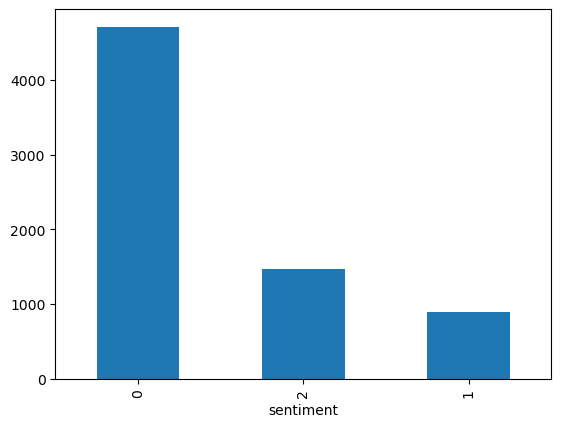

In [6]:
dataset['sentiment'].value_counts().plot(kind='bar')

As we can see the dataset is rather imbalanced so we will use undersampling

In [7]:
from imblearn.under_sampling import RandomUnderSampler
# Define features (X) and target (y)
X = dataset.drop('sentiment', axis=1)  # Assuming 'sentiment' is your target column
y = dataset['sentiment']

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled_df = pd.DataFrame(X_resampled, columns=['text'])  # Replace feature_columns with your actual feature names

# Convert y_resampled to a DataFrame or Series
y_resampled_df = pd.Series(y_resampled, name='sentiment')  # The column name 'sentiment' is based on your target variable

# Combine the features and target into a single DataFrame
balanced_dataset = pd.concat([X_resampled_df, y_resampled_df], axis=1)

<Axes: xlabel='sentiment'>

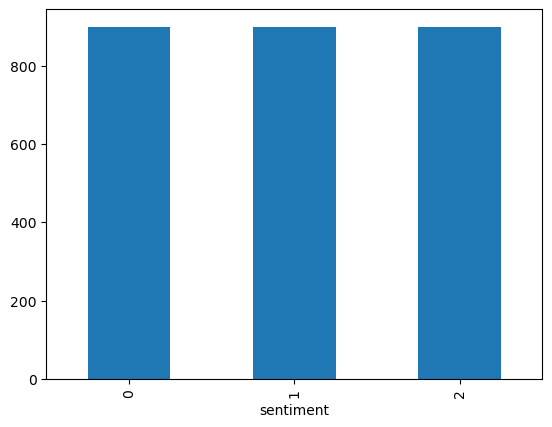

In [12]:
balanced_dataset['sentiment'].value_counts().plot(kind='bar')

In [13]:
dataset = balanced_dataset

## Tokenise and format text

In [8]:
def tokenizeAndFormatText(df, tokenizer):
    """
    Tokenize all texts and map the labels.

    Parameters:
    df (DataFrame): The dataset.
    tokenizer (BertTokenizer): The tokenizer.

    Returns:
    input_ids (list): The tokenized input ids.
    attention_masks (list): The attention masks.
    labels (list): The labels.
    """
    input_ids = []
    attention_masks = []
    labels = []

    for text, label in zip(df['text'], df['sentiment']):
        encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(label)

    return input_ids, attention_masks, labels

**Input IDs:** These are token IDs assigned to each token (word or subword) in the input text. BERT and similar models have a tokenizer that breaks down text into tokens and maps each token to a unique ID. These IDs are used by the model to understand and process the input text.

**Attention Masks:** Since inputs to models like BERT need to be of the same length, shorter sentences are padded with zeros. However, the model should only pay attention to the actual words, not the padding. Attention masks are binary (0s and 1s) masks that indicate which tokens in the input are words and which are padding. A 1 indicates a real token and a 0 indicates a padding token. This helps the model focus only on the relevant parts of the input.

**Labels:** In the context of supervised learning, such as sentiment analysis or classification tasks, labels represent the actual category or class each input text belongs to. For example, in sentiment analysis, labels might indicate whether a sentence has positive, negative, or neutral sentiment. The model uses these labels during training to learn how to predict the correct category for new, unseen inputs.

In [9]:
input_ids, attention_masks, labels = tokenizeAndFormatText(dataset, TOKENIZER)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/vincentlesang/miniconda3/envs/torch/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Convert everything to tensors

In [10]:
input_ids = torch.cat(input_ids, dim=0).to(DEVICE) # We convert the tensors to make them optimised for the corresponding devices
attention_masks = torch.cat(attention_masks, dim=0).to(DEVICE)
labels = torch.tensor(labels, device = DEVICE)

## Split data into the train and validation sets

In [11]:
# Split data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.15)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.15)

## Create the DataLoaders

In [12]:
# Create DataLoaders
batch_size = 32 # 32 is a common practice in machine learning (balance between computational efficiency and model performance)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Create and train the model

In [13]:
model = BertForSequenceClassification.from_pretrained(
    MODEL,
    num_labels = 3, 
    output_attentions = False, 
    output_hidden_states = False,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model.to(DEVICE) # Make the model optimised for our device

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8) # We load AdamW as an optimizer
# which is a kind of stochastic gradient descent

In [16]:
# Training Loop
# Note: This is a simplified version of the training loop
for epoch_i in range(0, 4):
    print('Running epoch {}...'.format(epoch_i))
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(DEVICE) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

Running epoch 0...
Running epoch 1...
Running epoch 2...
Running epoch 3...


## Model Evaluation

In [17]:
# Evaluation
model.eval()
predictions, true_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(DEVICE) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)

In [18]:
# Flatten the predictions and true values for aggregate classification report
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

Text(70.72222222222221, 0.5, 'True labels')

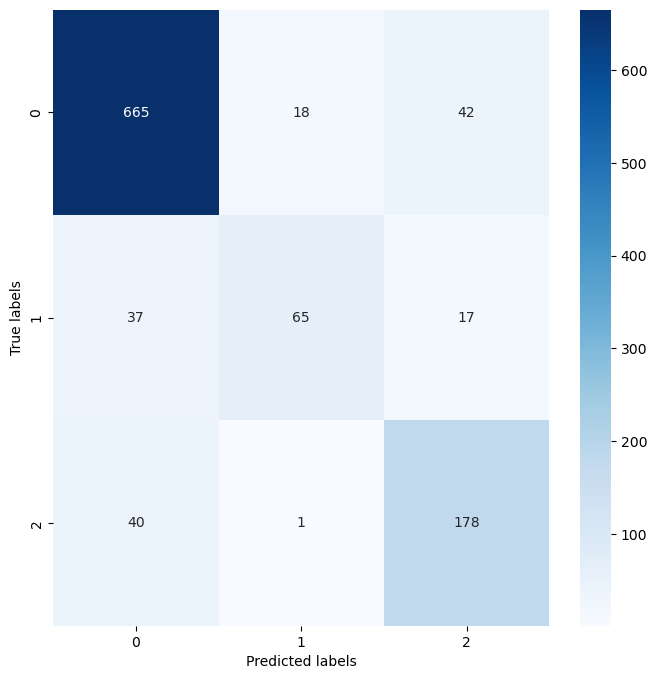

In [19]:
cm = confusion_matrix(flat_true_labels, flat_predictions)
plt.figure(figsize=(8, 8))
heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [20]:
accuracy = accuracy_score(flat_true_labels, flat_predictions)
report = classification_report(flat_true_labels, flat_predictions, target_names=['Neutral', 'Pro-Russian', 'Pro-Ukrainian'])

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.8541862652869238
Classification Report:
               precision    recall  f1-score   support

      Neutral       0.90      0.92      0.91       725
  Pro-Russian       0.77      0.55      0.64       119
Pro-Ukrainian       0.75      0.81      0.78       219

     accuracy                           0.85      1063
    macro avg       0.81      0.76      0.78      1063
 weighted avg       0.85      0.85      0.85      1063



## Save the model

In [22]:
# Save the model to a directory
model.save_pretrained(MODEL_SAVE_PATH)
TOKENIZER.save_pretrained(MODEL_SAVE_PATH)


('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json')